# 6. 뉴스 카테고리 다중분류 [프로젝트]
<br>

## 6-1. 프로젝트: Vocabulary Size를 변경해서 시도해보기
<br>

#### 라이브러리 import 및 버전 확인
<br>

In [24]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn

In [25]:
print(tf.__version__)
print(plt.matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


<br><br>

### 1. 모든 단어 사용
<br>

#### 훈련 및 테스트 데이터(로이터 뉴스) 로드하기
<br>

In [26]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [27]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [28]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


<br><br>

#### 데이터 분포 확인해보기
<br>

In [29]:
# 뉴스 데이터의 길이 분포 확인

In [30]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


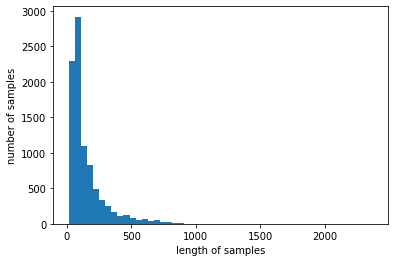

In [31]:
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

In [32]:
# 클래스 분포 확인

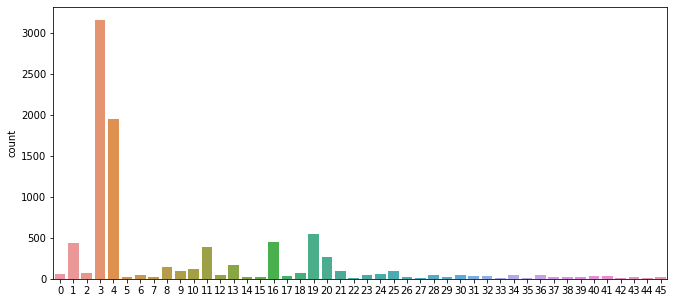

In [33]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

<br>

#### 원본 뉴스 데이터로 복원
<br>

In [34]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [35]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [36]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줌.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

<br>

In [37]:
# index_to_word를 통해서 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원해보기

In [38]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<br>

In [39]:
# 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환

In [40]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

In [41]:
x_train = decoded  # train 데이터 변환
print(len(x_train))

8982


In [42]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

In [43]:
x_test = decoded  # test 데이터 변환
print(len(x_test))

2246


<br><br>

#### 벡터화하기
<br>

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

##### DTM 생성

In [45]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

In [46]:
print(x_train_dtm.shape)

(8982, 26506)


##### TF-IDF 생성

In [47]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

In [48]:
print(tfidfv.shape)

(8982, 26506)


<br><br>

#### 머신러닝 모델 학습 및 예측
<br>

In [49]:
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score  

In [50]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

<br>

In [51]:
# 테스트 데이터에 대한 정확도를 측정하기 위해 테스트 데이터를 TF-IDF 행렬로 변환

In [52]:
x_test_dtm = dtmvector.transform(x_test)              # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) # DTM을 TF-IDF 행렬로 변환

<br>

##### 나이브 베이즈 분류기

In [53]:
model_nb = MultinomialNB()
model_nb.fit(tfidfv, y_train)

MultinomialNB()

In [54]:
predicted = model_nb.predict(tfidfv_test)     # 테스트 데이터에 대한 예측

In [55]:
accuracy = accuracy_score(y_test, predicted)  # 정확도 계산 (예측값과 실제값 비교)

In [56]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, predicted, average='weighted')  # F1 스코어 계산

In [57]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.5997328584149599
F1 스코어: 0.5045670886188423


##### Complement Naive Bayes Classifier(CNB)

In [58]:
model_cnb = ComplementNB()
model_cnb.fit(tfidfv, y_train)

ComplementNB()

In [59]:
predicted = model_cnb.predict(tfidfv_test)      

In [60]:
accuracy = accuracy_score(y_test, predicted)  

In [61]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [62]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.7649154051647373
F1 스코어: 0.7346534179503126


##### 로지스틱 회귀(Logistic Regression)

In [63]:
model_lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
model_lr.fit(tfidfv, y_train)  # 10분 정도 소요됨.

LogisticRegression(C=10000, max_iter=3000)

In [64]:
predicted = model_lr.predict(tfidfv_test)   

In [65]:
accuracy = accuracy_score(y_test, predicted)  

In [66]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [67]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.8165627782724845
F1 스코어: 0.8114428402876209


##### 선형 서포트 벡터 머신(LSVM)

In [68]:
model_lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
model_lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [69]:
predicted = model_lsvc.predict(tfidfv_test)   

In [70]:
accuracy = accuracy_score(y_test, predicted)  

In [71]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [72]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.7898486197684773
F1 스코어: 0.7857521258262028


##### 결정 트리(Decision Tree)

In [73]:
model_tree = DecisionTreeClassifier(max_depth=10, random_state=0)
model_tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [74]:
predicted = model_tree.predict(tfidfv_test)  

In [75]:
accuracy = accuracy_score(y_test, predicted)  

In [76]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [77]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.6211041852181657
F1 스코어: 0.5769283128518846


##### 랜덤 포레스트(Random Forest)

In [78]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=0) # 100개의 트리를 사용
model_forest.fit(tfidfv, y_train)

RandomForestClassifier(random_state=0)

In [79]:
predicted = model_forest.predict(tfidfv_test)   

In [80]:
accuracy = accuracy_score(y_test, predicted)  

In [81]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [82]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.7439893143365984
F1 스코어: 0.7170778830019511


##### 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [83]:
model_grbt = GradientBoostingClassifier(random_state=0)  # verbose=3
model_grbt.fit(tfidfv, y_train)  # 15분 정도 소요됨.

GradientBoostingClassifier(random_state=0)

In [84]:
predicted = model_grbt.predict(tfidfv_test)  

In [85]:
accuracy = accuracy_score(y_test, predicted)  

In [86]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [87]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.7702582368655387
F1 스코어: 0.7641672650539437


##### 보팅(Voting)

In [88]:
# VotingClassifier 생성 
voting_classifier = VotingClassifier(
    estimators=[
        ('model_lr', LogisticRegression(penalty='l2', random_state=0)),
        ('model_cnb', ComplementNB()),
        ('model_grbt', GradientBoostingClassifier(random_state=0))
    ],
    voting='soft' 
)

In [89]:
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('model_lr', LogisticRegression(random_state=0)),
                             ('model_cnb', ComplementNB()),
                             ('model_grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [90]:
predicted = voting_classifier.predict(tfidfv_test)

In [91]:
accuracy = accuracy_score(y_test, predicted)  

In [92]:
f1 = f1_score(y_test, predicted, average='weighted')  

In [93]:
print("정확도:", accuracy)
print("F1 스코어:", f1)

정확도: 0.8000890471950134
F1 스코어: 0.7944945456027671


<br><br>

### 2. 빈도수 상위 5,000개의 단어만 사용
<br>

#### 훈련 및 테스트 데이터(로이터 뉴스) 로드하기
<br>

In [71]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

<br>

#### 원본 뉴스 데이터로 복원
<br>

In [72]:
# index_to_word를 통해서 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원해보기

In [73]:
print(' '.join([index_to_word[index] for index in x_train_5k[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<br>

In [74]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word.get(index, '<unk>') for index in x_train_5k[i]]) # get 메서드 사용하여 인덱스가 없으면 '<unk>' 반환
    decoded.append(t)

In [75]:
x_train_5k = decoded
print(len(x_train_5k))

8982


In [76]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word.get(index, '<unk>') for index in x_test_5k[i]]) # get 메서드 사용하여 인덱스가 없으면 '<unk>' 반환
    decoded.append(t)

In [77]:
x_test_5k = decoded
print(len(x_test_5k))

2246


<br>

#### 벡터화하기

##### DTM 생성

In [78]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)

In [79]:
print(x_train_dtm_5k.shape)

(8982, 4867)


##### TF-IDF 생성

In [80]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)

In [81]:
print(tfidfv_5k.shape)

(8982, 4867)


<br>

#### 머신러닝 모델 학습
<br>

In [82]:
# 데이터를 TF-IDF 행렬로 변환

In [83]:
x_test_dtm_5k = dtmvector.transform(x_test_5k)               # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k)  # DTM을 TF-IDF 행렬로 변환

<br>

In [84]:
# 모델별 훈련 및 예측 

In [85]:
def train_predict(tfidfv, y_train, tfidfv_test, y_test):
    # 1) 나이브 베이즈 분류기
    model_nb = MultinomialNB()
    model_nb.fit(tfidfv, y_train)
    
    predicted = model_nb.predict(tfidfv_test)     
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_나이브 베이즈 분류기:", accuracy)
    print("F1 스코어:", f1)
    print()
    
    # 2) Complement Naive Bayes Classifier(CNB)
    model_cnb = ComplementNB()
    model_cnb.fit(tfidfv, y_train)
    
    predicted = model_cnb.predict(tfidfv_test)     
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted') 
    print("정확도_CNB:", accuracy)
    print("F1 스코어:", f1)
    print()
    
    # 3) 로지스틱 회귀(Logistic Regression)
    model_lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
    model_lr.fit(tfidfv, y_train) 
    
    predicted = model_lr.predict(tfidfv_test)     
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_로지스틱 회귀:", accuracy)  
    print("F1 스코어:", f1)
    print()
    
    # 4) 선형 서포트 벡터 머신(LSVM)
    model_lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
    model_lsvc.fit(tfidfv, y_train)
    
    predicted = model_lsvc.predict(tfidfv_test)            
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_LSVM:", accuracy)
    print("F1 스코어:", f1)
    print()
    
    # 5) 결정 트리(Decision Tree)
    model_tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    model_tree.fit(tfidfv, y_train)
    
    predicted = model_tree.predict(tfidfv_test)          
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_Decision Tree:", accuracy)
    print("F1 스코어:", f1)
    print()
    
    # 6) 랜덤 포레스트(Random Forest)
    model_forest = RandomForestClassifier(n_estimators=100, random_state=0) # 100개의 트리를 사용
    model_forest.fit(tfidfv, y_train)
    
    predicted = model_forest.predict(tfidfv_test)  
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_Random Forest:", accuracy)
    print("F1 스코어:", f1)
    print()
    
    # 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)
    model_grbt = GradientBoostingClassifier(random_state=0)  # verbose=3
    model_grbt.fit(tfidfv, y_train)  # 15분 정도 소요됨.
    
    predicted = model_grbt.predict(tfidfv_test)           
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_GradientBoosting:", accuracy_score(y_test, predicted))  
    print("F1 스코어:", f1)
    print()
    
    # 8) 보팅(Voting)
    voting_classifier = VotingClassifier(
        estimators=[
            ('model_lr', LogisticRegression(penalty='l2', random_state=0)),
            ('model_cnb', ComplementNB()),
            ('model_grbt', GradientBoostingClassifier(random_state=0))
        ],
        voting='soft' 
    )
    voting_classifier.fit(tfidfv, y_train)
    
    predicted = voting_classifier.predict(tfidfv_test)
    accuracy = accuracy_score(y_test, predicted)  
    f1 = f1_score(y_test, predicted, average='weighted')  
    print("정확도_Voting:", accuracy_score(y_test, predicted))
    print("F1 스코어:", f1)
    print()
    
    return model_nb, model_cnb, model_lr, model_lsvc, model_tree, model_forest, model_grbt, voting_classifier

In [86]:
model_nb_5k, model_cnb_5k, model_lr_5k, model_lsvc_5k, model_tree_5k, model_forest_5k, model_grbt_5k, voting_classifier_5k = train_predict(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k) 

정확도_나이브 베이즈 분류기: 0.6731967943009796
F1 스코어: 0.6012501291711391

정확도_CNB: 0.7707034728406055
F1 스코어: 0.7458990404916549

정확도_로지스틱 회귀: 0.8036509349955476
F1 스코어: 0.7985602317931111



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도_LSVM: 0.7702582368655387
F1 스코어: 0.7664213009501786

정확도_Decision Tree: 0.6179875333926982
F1 스코어: 0.5729970881280324

정확도_Random Forest: 0.7582368655387355
F1 스코어: 0.7336825176596649

정확도_GradientBoosting: 0.767586821015138
F1 스코어: 0.7662475269931749



/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도_Voting: 0.7960819234194123
F1 스코어: 0.7931448977062081



<br><br>

### 3. 직접 단어 개수를 설정해서 사용
<br>

#### 1) 20000개
<br>

In [87]:
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)

<br>

In [88]:
print(' '.join([index_to_word[index] for index in x_train_20k[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<br>

In [89]:
decoded = []
for i in range(len(x_train_20k)):
    t = ' '.join([index_to_word[index] for index in x_train_20k[i]])
    decoded.append(t)

In [90]:
x_train_20k = decoded
print(len(x_train_20k))

8982


In [91]:
decoded = []
for i in range(len(x_test_20k)):
    t = ' '.join([index_to_word[index] for index in x_test_20k[i]])
    decoded.append(t)

In [92]:
x_test_20k = decoded
print(len(x_test_20k))

2246


<br>

In [93]:
dtmvector = CountVectorizer()
x_train_dtm_20k = dtmvector.fit_transform(x_train_20k)

In [94]:
print(x_train_dtm_20k.shape)

(8982, 18479)


In [95]:
tfidf_transformer = TfidfTransformer()
tfidfv_20k = tfidf_transformer.fit_transform(x_train_dtm_20k)

In [96]:
print(tfidfv_20k.shape)

(8982, 18479)


<br>

In [97]:
x_test_dtm_20k = dtmvector.transform(x_test_20k) 
tfidfv_test_20k = tfidf_transformer.transform(x_test_dtm_20k) 

<br>

In [21]:
def train_predict(tfidfv, y_train, tfidfv_test, y_test):
    models = {
        '나이브 베이즈 분류기': MultinomialNB(),
        'CNB': ComplementNB(),
        '로지스틱 회귀': LogisticRegression(C=10000, penalty='l2', max_iter=3000),
        'LSVM': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=0),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
        'GradientBoosting': GradientBoostingClassifier(random_state=0),
    }
    
    # Voting Classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('model_lr', models['로지스틱 회귀']),
            ('model_cnb', models['CNB']),
            ('model_grbt', models['GradientBoosting'])
        ],
        voting='soft' 
    )
    
    # Voting Classifier를 models 딕셔너리에 추가
    models['Voting'] = voting_classifier
    
    for name, model in models.items():
        model.fit(tfidfv, y_train)
        predicted = model.predict(tfidfv_test)
        accuracy = accuracy_score(y_test, predicted)
        f1 = f1_score(y_test, predicted, average='weighted')
        print(f"정확도_{name}:", accuracy)
        print("F1 스코어:", f1)
        print()
    
    return models

In [99]:
model_nb_20k, model_cnb_20k, model_lr_20k, model_lsvc_20k, model_tree_20k, model_forest_20k, model_grbt_20k, voting_classifier_20k = train_predict(tfidfv_20k, y_train_20k, tfidfv_test_20k, y_test_20k) 

정확도_나이브 베이즈 분류기: 0.6193232413178985
F1 스코어: 0.5315181088041159

정확도_CNB: 0.7671415850400712
F1 스코어: 0.7390612170450325

정확도_로지스틱 회귀: 0.8156723063223509
F1 스코어: 0.8104596865918853



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도_LSVM: 0.7951914514692787
F1 스코어: 0.7914930707307288

정확도_Decision Tree: 0.6211041852181657
F1 스코어: 0.576123209915252

정확도_Random Forest: 0.7457702582368655
F1 스코어: 0.7209992521057289

정확도_GradientBoosting: 0.7702582368655387
F1 스코어: 0.7647126117421563

정확도_Voting: 0.8192341941228851
F1 스코어: 0.8159632601545135



<br><br>

#### 2) 10000개 사용
<br>

In [4]:
(x_train_10k, y_train_10k), (x_test_10k, y_test_10k) = reuters.load_data(num_words=10000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


<br>

In [9]:
print(' '.join([index_to_word[index] for index in x_train_10k[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<br>

In [10]:
def decode_data(data, index_to_word):
    decoded = [' '.join([index_to_word[index] for index in item]) for item in data]
    return decoded

In [11]:
x_train_10k = decode_data(x_train_10k, index_to_word)
print(len(x_train_10k))

8982


In [12]:
x_test_10k = decode_data(x_test_10k, index_to_word)
print(len(x_test_10k))

2246


<br>

In [17]:
dtmvector = CountVectorizer()
x_train_dtm_10k = dtmvector.fit_transform(x_train_10k)
print(x_train_dtm_10k.shape)

(8982, 9670)


In [18]:
tfidf_transformer = TfidfTransformer()
tfidfv_10k = tfidf_transformer.fit_transform(x_train_dtm_10k)
print(tfidfv_10k.shape)

(8982, 9670)


<br>

In [19]:
x_test_dtm_10k = dtmvector.transform(x_test_10k) 
tfidfv_test_10k = tfidf_transformer.transform(x_test_dtm_10k) 

<br>

In [22]:
model_nb_10k, model_cnb_10k, model_lr_10k, model_lsvc_10k, model_tree_10k, model_forest_10k, model_grbt_10k, voting_classifier_10k = train_predict(tfidfv_10k, y_train_10k, tfidfv_test_10k, y_test_10k) 

정확도_나이브 베이즈 분류기: 0.6567230632235085
F1 스코어: 0.5764467518778252

정확도_CNB: 0.7707034728406055
F1 스코어: 0.7456682614453047

정확도_로지스틱 회귀: 0.8107747105966162
F1 스코어: 0.8056804816074952



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도_LSVM: 0.7880676758682101
F1 스코어: 0.7839892901900612

정확도_Decision Tree: 0.6202137132680321
F1 스코어: 0.5776398779280149

정확도_Random Forest: 0.7582368655387355
F1 스코어: 0.7343814459663163

정확도_GradientBoosting: 0.7662511130899377
F1 스코어: 0.7622247724249729

정확도_Voting: 0.8165627782724845
F1 스코어: 0.8133719894789346



<br><br>

### 단어 개수와 분류 모델에 따른 accuracy 및 F1 Score 분석
<br>

#### 1) 모든 단어 사용 시
<br>

+ Naive Bayes Classifier_정확도: 0.5997328584149599
+ Naive Bayes Classifier_F1 스코어: 0.5045670886188423

+ CNB_정확도: 0.7649154051647373
+ CNB_F1 스코어: 0.7346534179503126

+ Logistic Regression_정확도: 0.8165627782724845
+ Logistic Regression_F1 스코어: 0.8114428402876209

+ LSVM_정확도: 0.792520035618878
+ LSVM_F1 스코어: 0.7881674006745751

+ Decision Tree_정확도: 0.6211041852181657
+ Decision Tree_F1 스코어: 0.5769283128518846

+ Random Forest_정확도: 0.7439893143365984
+ Random Forest_F1 스코어: 0.7170778830019511

+ GradientBoosting_정확도: 0.7702582368655387
+ GradientBoosting_F1 스코어: 0.7641672650539437

+ Voting_정확도: 0.8000890471950134
+ Voting_F1 스코어: 0.7944945456027671

<br>

#### 2) 빈도수 상위 5,000개의 단어만 사용
<br>

+ Naive Bayes Classifier_정확도: 0.6731967943009796
+ Naive Bayes Classifier_F1 스코어: 0.6012501291711391

+ CNB_정확도: 0.7707034728406055
+ CNB_F1 스코어: 0.7458990404916549

+ Logistic Regression_정확도: 0.8036509349955476
+ Logistic Regression_F1 스코어: 0.7985602317931111

+ LSVM_정확도: 0.7711487088156723
+ LSVM_F1 스코어: 0.7657729937713968

+ Decision Tree_정확도: 0.6179875333926982
+ Decision Tree_F1 스코어: 0.5729970881280324

+ Random Forest_정확도: 0.7582368655387355
+ Random Forest_F1 스코어: 0.7336825176596649

+ GradientBoosting_정확도: 0.767586821015138
+ GradientBoosting_F1 스코어: 0.7662475269931749

+ Voting_정확도: 0.7960819234194123
+ Voting_F1 스코어: 0.7931448977062081

<br>

#### 3-1) 20000개 사용 시
<br>

+ Naive Bayes Classifier_정확도: 0.6193232413178985
+ Naive Bayes Classifier_F1 스코어: 0.5315181088041159

+ CNB_정확도: 0.7671415850400712
+ CNB_F1 스코어: 0.7390612170450325

+ Logistic Regression_정확도: 0.8156723063223509
+ Logistic Regression_F1 스코어: 0.8104596865918853

+ LSVM_정확도: 0.7911843276936776
+ LSVM_F1 스코어: 0.7868030009435951

+ Decision Tree_정확도: 0.6211041852181657
+ Decision Tree_F1 스코어: 0.576123209915252

+ Random Forest_정확도: 0.7457702582368655
+ Random Forest_F1 스코어: 0.7209992521057289

+ GradientBoosting_정확도: 0.7702582368655387
+ GradientBoosting_F1 스코어: 0.7647126117421563

+ Voting_정확도: 0.8192341941228851
+ Voting_F1 스코어: 0.8159632601545135

<br>

#### 3-2) 10000개 사용 시
<br>

+ Naive Bayes Classifier_정확도: 0.6567230632235085
+ Naive Bayes Classifier_F1 스코어: 0.5764467518778252

+ CNB_정확도: 0.7707034728406055
+ CNB_F1 스코어: 0.7456682614453047

+ Logistic Regression_정확도: 0.8107747105966162
+ Logistic Regression_F1 스코어: 0.8056804816074952

+ LSVM_정확도: 0.784060552092609
+ LSVM_F1 스코어: 0.7794624441868488

+ Decision Tree_정확도: 0.6202137132680321
+ Decision Tree_F1 스코어: 0.5776398779280149

+ Random Forest_정확도: 0.7582368655387355
+ Random Forest_F1 스코어: 0.7343814459663163

+ GradientBoosting_정확도: 0.7662511130899377
+ GradientBoosting_F1 스코어: 0.7622247724249729

+ Voting_정확도: 0.8165627782724845
+ Voting_F1 스코어: 0.8133719894789346

<br><br>

### 4. 딥러닝 모델과 비교해 보기
<br>

#### RNN(LSTM) 모델로 학습하기
<br>

In [158]:
# 20,000개의 단어 dataset 이용

In [159]:
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)

<br>

In [160]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [161]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [162]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

<br>

In [163]:
print(' '.join([index_to_word[index] for index in x_train_20k[1]]))

<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3


<br>

In [164]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [167]:
vocab_size = len(index_to_word) + 1
word_vector_dim = 512
maxlen = 200
num_classes = max(y_train_20k) + 1

In [165]:
def pad_sequences(sequences, maxlen):
    return keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=maxlen)

<br>

##### model 1
<br>

In [166]:
def build_lstm_model(vocab_size, word_vector_dim, maxlen, num_classes):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)),
        keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

<br>

In [168]:
# 시퀀스 패딩처리
x_train_pad = pad_sequences(x_train_20k, maxlen)
x_test_pad = pad_sequences(x_test_20k, maxlen)

In [106]:
# 모델 구현
model_LSTM = build_lstm_model(vocab_size, word_vector_dim, maxlen, num_classes)
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 512)          15863296  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                69760     
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 15,943,214
Trainable params: 15,943,214
Non-trainable params: 0
_________________________________________________________________


<br>

In [107]:
# 모델 컴파일
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [110]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [169]:
# 모델 훈련
history = model_LSTM.fit(x_train_pad, y_train_20k, 
                         batch_size=128, 
                         epochs=20, 
                         validation_split=0.2,
                         callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 98s 2s/step - loss: 0.3163 - accuracy: 0.9236 - val_loss: 1.3722 - val_accuracy: 0.7086
Epoch 2/20
57/57 [==============================] - 97s 2s/step - loss: 0.2679 - accuracy: 0.9329 - val_loss: 1.4424 - val_accuracy: 0.7119
Epoch 3/20
57/57 [==============================] - 97s 2s/step - loss: 0.2389 - accuracy: 0.9395 - val_loss: 1.5472 - val_accuracy: 0.7063
Epoch 4/20
57/57 [==============================] - 98s 2s/step - loss: 0.2255 - accuracy: 0.9422 - val_loss: 1.6260 - val_accuracy: 0.6986


<br>

In [201]:
# 훈련 결과 시각화

In [170]:
import matplotlib.pyplot as plt

In [171]:
# Get training and validation loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

In [172]:
# Get training and validation accuracy histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

In [173]:
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

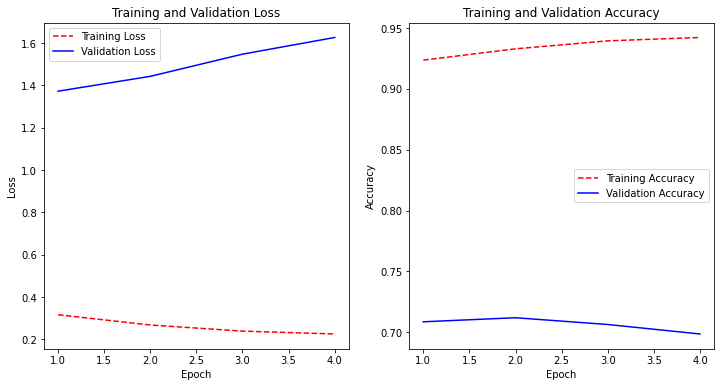

In [174]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

<br><br>

##### model 2
<br>

In [175]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Dropout

def build_lstm_model(vocab_size, word_vector_dim, maxlen, num_classes):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)),
        Bidirectional(keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)), # Bidirectional LSTM with 64 cells
        keras.layers.Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), # Dropout layer with 50% dropout rate
        keras.layers.Dense(64, activation='relu'), # Additional Dense layer
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [176]:
# 모델 구현
model_LSTM = build_lstm_model(vocab_size, word_vector_dim, maxlen, num_classes)
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 512)          15863296  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               295424    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 46)               

<br>

In [177]:
# 모델 컴파일
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [178]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [179]:
# 모델 훈련
history = model_LSTM.fit(x_train_pad, y_train_20k, 
                         batch_size=128, 
                         epochs=20, 
                         validation_split=0.2,
                         callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 105s 2s/step - loss: 2.3207 - accuracy: 0.4600 - val_loss: 2.8632 - val_accuracy: 0.5364
Epoch 2/20
57/57 [==============================] - 99s 2s/step - loss: 1.5022 - accuracy: 0.6296 - val_loss: 2.8857 - val_accuracy: 0.5910
Epoch 3/20
57/57 [==============================] - 100s 2s/step - loss: 1.1863 - accuracy: 0.7047 - val_loss: 2.3389 - val_accuracy: 0.6672
Epoch 4/20
57/57 [==============================] - 99s 2s/step - loss: 0.9006 - accuracy: 0.7772 - val_loss: 1.8461 - val_accuracy: 0.6644
Epoch 5/20
57/57 [==============================] - 99s 2s/step - loss: 0.7063 - accuracy: 0.8249 - val_loss: 1.5476 - val_accuracy: 0.7134
Epoch 6/20
57/57 [==============================] - 99s 2s/step - loss: 0.5477 - accuracy: 0.8610 - val_loss: 1.3504 - val_accuracy: 0.7340
Epoch 7/20
57/57 [==============================] - 100s 2s/step - loss: 0.4311 - accuracy: 0.8946 - val_loss: 1.2177 - val_accuracy: 0.7329
Epoch 8/20
57/57 

<br>

In [196]:
# 훈련 결과 시각화

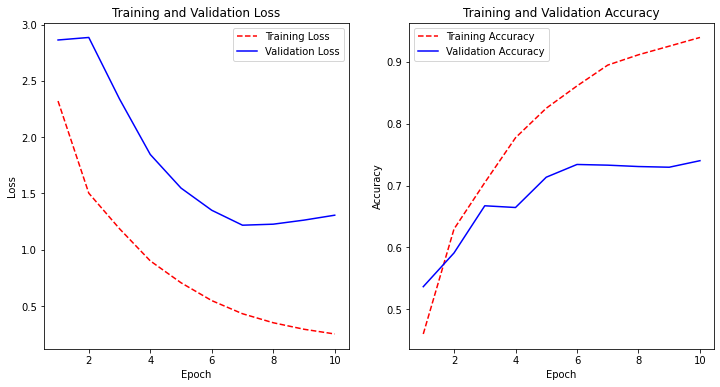

In [180]:
# Get training and validation loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get training and validation accuracy histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

<br>

In [197]:
# 모델 평가

In [181]:
test_loss, test_accuracy = model_LSTM.evaluate(x_test_pad, y_test_20k)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

71/71 [==============================] - 8s 108ms/step - loss: 1.2657 - accuracy: 0.7195
Test Loss: 1.2657110691070557
Test Accuracy: 0.7195013165473938


<br>

In [198]:
# 모델 예측

In [182]:
# Predict the classes for the test data
predictions = model_LSTM.predict(x_test_pad)

# Select the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# If you want to see some examples
for i in range(5):
    print(f"Predicted class: {predicted_classes[i]}, Actual class: {y_test_20k[i]}")

Predicted class: 4, Actual class: 3
Predicted class: 19, Actual class: 10
Predicted class: 24, Actual class: 1
Predicted class: 16, Actual class: 4
Predicted class: 13, Actual class: 4


<br>

In [200]:
# F1 Score 계산

In [183]:
from sklearn.metrics import f1_score

# Compute the F1 score
f1 = f1_score(y_test_20k, predicted_classes, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7057660897478802


In [184]:
from sklearn.metrics import classification_report

# 모델을 사용하여 테스트 데이터에 대한 예측을 수행
y_pred = model_LSTM.predict(x_test_pad)
predicted_classes = np.argmax(y_pred, axis=1)

# classification_report를 사용하여 결과를 출력
report = classification_report(y_test_20k, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.33      0.47        12
           1       0.61      0.75      0.67       105
           2       0.31      0.40      0.35        20
           3       0.89      0.91      0.90       813
           4       0.81      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       1.00      0.71      0.83        14
           7       0.00      0.00      0.00         3
           8       0.66      0.55      0.60        38
           9       0.47      0.64      0.54        25
          10       0.69      0.67      0.68        30
          11       0.55      0.49      0.52        83
          12       0.29      0.15      0.20        13
          13       0.33      0.27      0.30        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.53      0.71      0.60        99
          17       0.11    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<br>

In [199]:
# Confusion Matrix 계산 및 시각화

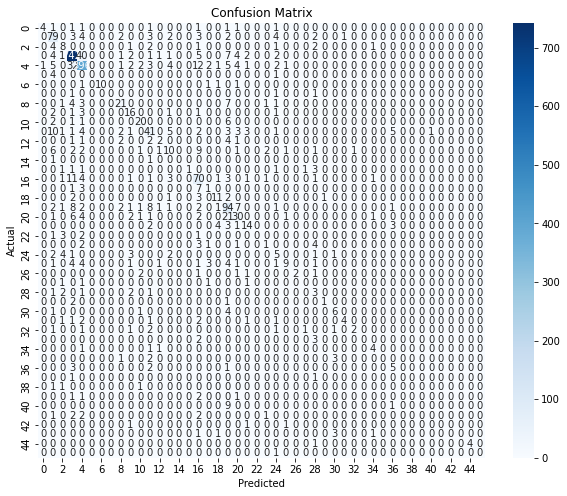

In [185]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_20k, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<br><br>

##### model 3
<br>

In [186]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

def build_lstm_model(vocab_size, word_vector_dim, maxlen, num_classes):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)),
        Bidirectional(keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.0005))), # Increased LSTM units and reduced regularization
        keras.layers.Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4), # Reduced Dropout rate
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [187]:
# 모델 컴파일
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [188]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [189]:
# 모델 훈련
history = model_LSTM.fit(x_train_pad, y_train_20k, 
                         batch_size=128, 
                         epochs=20, 
                         validation_split=0.2,
                         callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 104s 2s/step - loss: 0.3705 - accuracy: 0.9055 - val_loss: 1.1619 - val_accuracy: 0.7479
Epoch 2/20
57/57 [==============================] - 99s 2s/step - loss: 0.2845 - accuracy: 0.9241 - val_loss: 1.2547 - val_accuracy: 0.7474
Epoch 3/20
57/57 [==============================] - 98s 2s/step - loss: 0.2417 - accuracy: 0.9382 - val_loss: 1.3611 - val_accuracy: 0.7379
Epoch 4/20
57/57 [==============================] - 98s 2s/step - loss: 0.2279 - accuracy: 0.9389 - val_loss: 1.4928 - val_accuracy: 0.7334


<br>

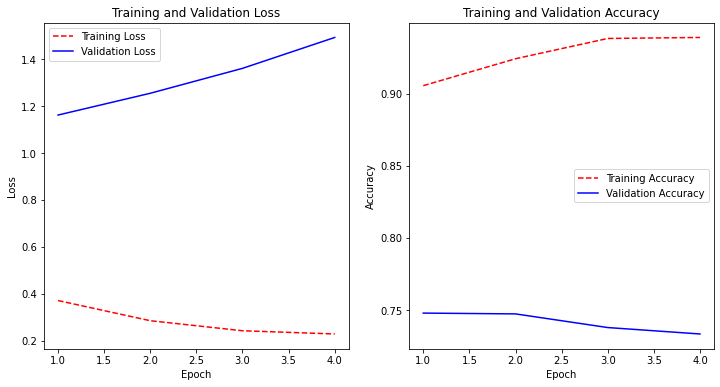

In [190]:
# Get training and validation loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get training and validation accuracy histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

<br>

In [191]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_LSTM.evaluate(x_test_pad, y_test_20k)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

71/71 [==============================] - 8s 108ms/step - loss: 1.2369 - accuracy: 0.7208
Test Loss: 1.2369310855865479
Test Accuracy: 0.7208370566368103


<br>

In [192]:
# Predict the classes for the test data
predictions = model_LSTM.predict(x_test_pad)

# Select the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# If you want to see some examples
for i in range(5):
    print(f"Predicted class: {predicted_classes[i]}, Actual class: {y_test_20k[i]}")

Predicted class: 3, Actual class: 3
Predicted class: 19, Actual class: 10
Predicted class: 1, Actual class: 1
Predicted class: 16, Actual class: 4
Predicted class: 13, Actual class: 4


<br>

In [193]:
from sklearn.metrics import f1_score

# Compute the F1 score
f1 = f1_score(y_test_20k, predicted_classes, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.7091302976316546


In [194]:
from sklearn.metrics import classification_report

# 모델을 사용하여 테스트 데이터에 대한 예측을 수행
y_pred = model_LSTM.predict(x_test_pad)
predicted_classes = np.argmax(y_pred, axis=1)

# classification_report를 사용하여 결과를 출력
report = classification_report(y_test_20k, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.33      0.42        12
           1       0.63      0.72      0.68       105
           2       0.62      0.40      0.48        20
           3       0.91      0.91      0.91       813
           4       0.79      0.84      0.81       474
           5       0.00      0.00      0.00         5
           6       1.00      0.71      0.83        14
           7       0.00      0.00      0.00         3
           8       0.59      0.61      0.60        38
           9       0.82      0.56      0.67        25
          10       0.78      0.70      0.74        30
          11       0.49      0.60      0.54        83
          12       0.33      0.08      0.12        13
          13       0.31      0.43      0.36        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.48      0.72      0.57        99
          17       0.00    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<br>

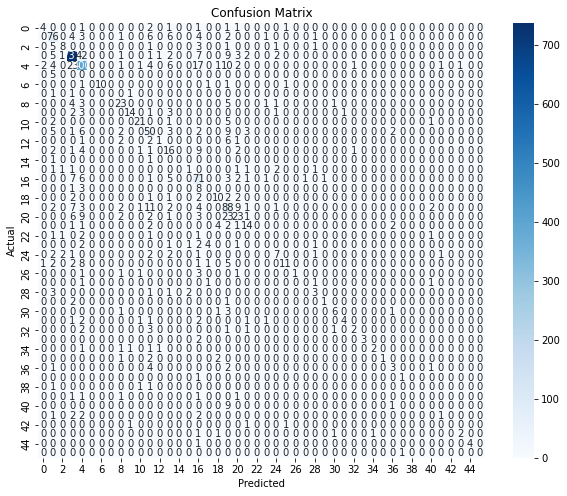

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_20k, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<br><br>

## 6-2. 프로젝트 제출
<br>

### 루브릭
<br>

#### 평가문항과 상세기준
<br>

##### 1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?

3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출

<br>

##### 2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.

<br>

##### 3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.